# Ch.13 Statistics
The notebook focuses on some applications of statistics in finance

* Normality test
* Portfolio optimization
* Bayesian statistics
* Machine learning

In [1]:
import math
import numpy as np  
import scipy.stats as scs
import statsmodels.api as sm
import pandas as pd
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4
Pandas version: 2.2.2


## Normality test
It is assumed in many theoretical studies in finance that the returns are normally distributed. This normal distribution is also a baseline when other distributions are discussed. The normal distribution is assumed for the stock price in portfolio theory and in the capital asset pricing model. It is also assumed in the efficient market hypothesis and in the Black-Scholes-Merton option pricing model. The BSM model is a stochastic equation that can be discretized as

$$S_t = S_{t - \Delta t} \exp((r - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t}z)$$

The index level S is a drift-diffusion model where the first term in the right-hand side of the equation represents the drift and the second term represents the brownian motion.

### Normality test in simulations
We use synthetic data to simulate random processes and financial time series. We take a number of M=50 samples, one for each time step $\Delta$, of size I=250000 of the simulated BSM process. Every sample contains I stochastic values and at each time step a new value is calculated for each of them, following the BSM equation. We store the samples as rows of an array S where the columns are the time steps. A row represents a time series, that is the evolution, or path, of one single random variable in M time steps. A column represents the I random variables at a particular time step. using only one time series would not be enough to statistically describe the stochastic process under observation. 

In [2]:
def gen_paths(S0, r, sigma, T, M, I):
    ''' Generate Monte Carlo paths for geometric Brownian motion.
    
    Parameters
    ==========
    S0: float
        initial stock/index value
    r: float
        constant short rate
    sigma: float
        constant volatility
    T: float
        final time horizon
    M: int
        number of time steps/intervals
    I: int
        number of paths to be simulated
        
    Returns
    =======
    paths: ndarray, shape (M + 1, I)
        simulated paths given the parameters
    '''
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()  
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * math.sqrt(dt) * rand)  
    return paths

In [3]:
S0 = 100.  
r = 0.05  
sigma = 0.2  
T = 1.0   
M = 50  
I = 250000  
np.random.seed(1000)

In [4]:
paths = gen_paths(S0, r, sigma, T, M, I)
paths.shape

(51, 250000)

In [5]:
S0 * math.exp(r * T)

105.12710963760242

We plot the paths of a subset of the I BSM processes

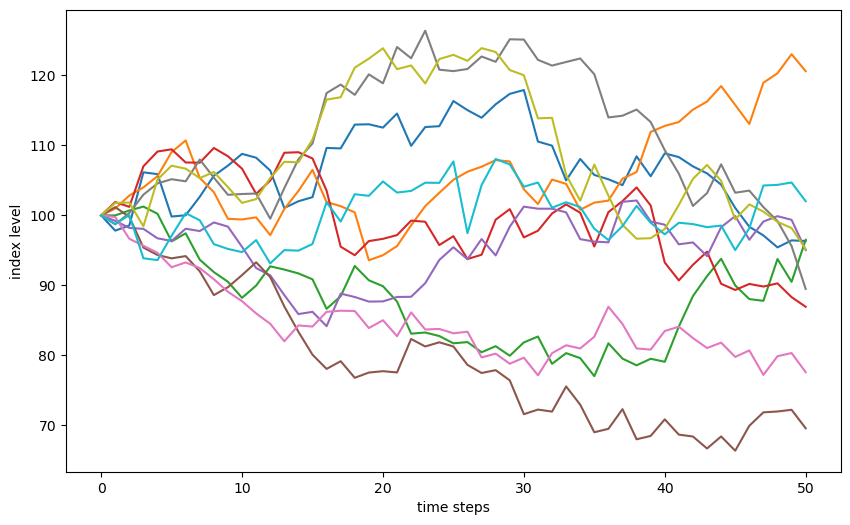

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(paths[:, :10])
plt.xlabel('time steps')
plt.ylabel('index level');

#### Log-returns
The log-returns are defined as 

$$log (\frac{S_t}{S_{t - \Delta t}}) = (r - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t}z $$

In [7]:
paths_t1 = paths[:-1]
paths_t1.shape

(50, 250000)

In [8]:
paths_t2 = paths[1:]
paths_t2.shape

(50, 250000)

In [60]:
log_returns = np.log(paths_t2 / paths_t1)
log_returns.shape

(50, 250000)

In [10]:
path0_log_returns = log_returns[:, 0]

In [11]:
def print_statistics(array):
    ''' Prints selected statistics.
        Parameters
        ==========
        array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

We calculate the main moments of the I log-returns of length M. As we can see, both skewness and kurtosis are close to zero meaning that the log-returns are normally distributed.

In [12]:
print_statistics(log_returns.flatten())

     statistic           value
------------------------------
          size  12500000.00000
           min        -0.15664
           max         0.15371
          mean         0.00060
           std         0.02828
          skew         0.00055
      kurtosis         0.00085


We can calculate the yearly mean of log-returns. We can see that, after correcting with the Ito term $\frac{1}{2} \sigma^2$  it is the same as the risk-free return.

In [17]:
yearly_mean_log_return = log_returns.mean() * M + 0.5 * sigma ** 2
yearly_mean_log_return

0.05000000000000006

From the histogram of the log-returns and the plot of the Gaussian distribution, with the same mean and standard deviation, we can see that log-returns are indeed normally distributed. 

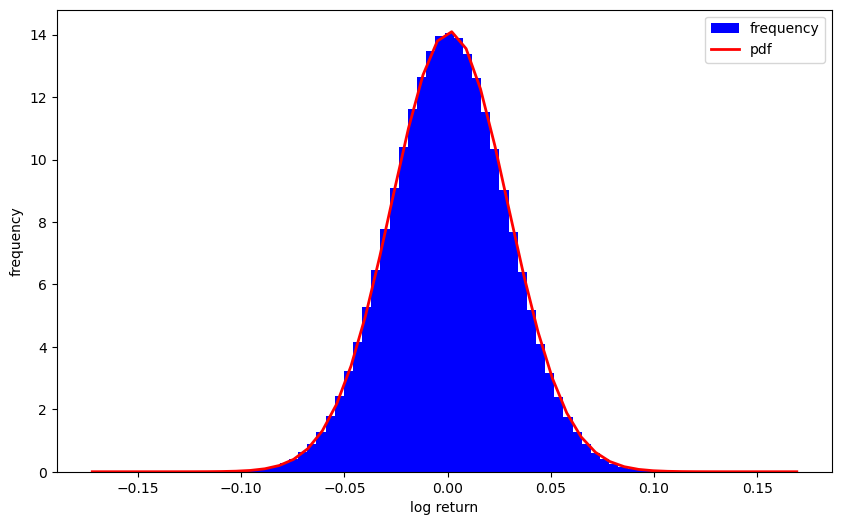

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(log_returns.flatten(), bins=70, density=True,
label='frequency', color='b')
plt.xlabel('log return')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=r / M, scale=sigma / np.sqrt(M)), 'r', lw=2.0, label='pdf')
plt.legend();

Another way to compare two distributions is by a quantile-quantile plot. Here we use the qqplot method of the [statsmodel](https://www.statsmodels.org/devel/generated/statsmodels.graphics.gofplots.qqplot.html) package to compare the log-returns with the default normal distribution.

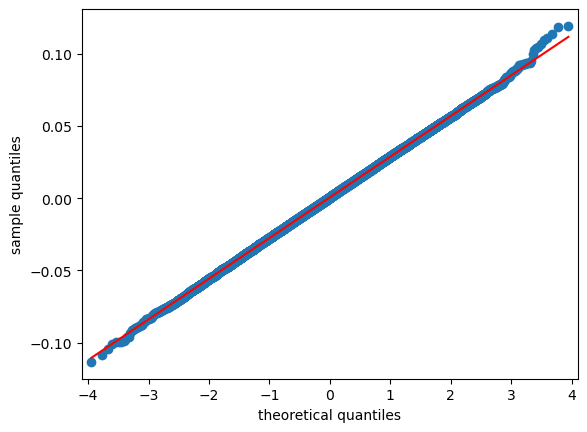

In [19]:
sm.qqplot(log_returns.flatten()[::500], line='s')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles');

Assuming the null hypothesis that the synthetic data is normally distributed we perform the normality tests based on the SciPy methods to calculate the skewness and the kurtosis. As we can see from the results, both skewness and kurtosis are very close to the values of a Gaussian distribution and since the p-values are practically zero we accept the null hypothesis. 

In [20]:
def normality_tests(arr):
    ''' Tests for normality distribution of given data set.
    Parameters
    ==========
    array: ndarray
    object to generate statistics on
    '''
    print('Skew of data set %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])

In [48]:
normality_tests(log_returns.flatten())

Skew of data set          0.001
Skew test p-value          0.430
Kurt of data set          0.001
Kurt test p-value          0.541
Norm test p-value          0.607


In [62]:
significance_level = 0.01
p_value = scs.normaltest(log_returns.flatten())[1]
if (p_value > significance_level):
    print('The Null hypothesis cannot be rejected at the {:.1f}% significance level'.format((1 - significance_level) * 100))
else:
    print('The null hypothesis must be rejected at the {:.1f}% significance level'.format((1 - significance_level) * 100))

The Null hypothesis cannot be rejected at the 99.0% significance level


We plot the data at the last time step, that is the values of the I variables after M time steps, and the its logarithm to compare the two distributions. The log data is normally distributed and the original data is log-normally distributed, as expected. 

Text(0.5, 1.0, 'log data')

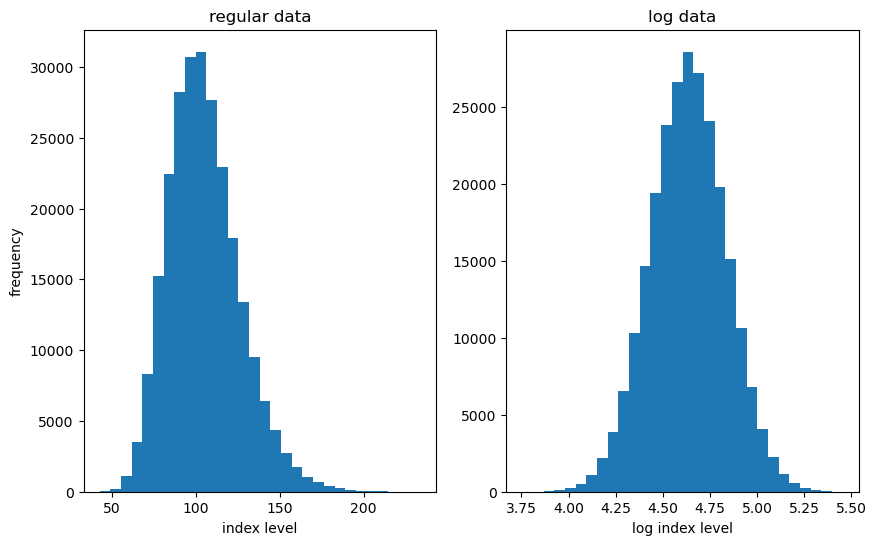

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(paths[-1], bins=30)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.set_title('regular data')
ax2.hist(np.log(paths[-1]), bins=30)
ax2.set_xlabel('log index level')
ax2.set_title('log data')

### Normality test for real-world data
Now we use stock data to assess whether they are normally distributed, as we assumed in the simulation, or they differ in some ways from a normal distribution.

In [23]:
filename = 'source/tr_eikon_eod_data.csv'  
with open(filename, 'r') as f:   
    print(f.readlines()[:5])  

['Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD\n', '2010-01-01,,,,,,,,,1.4323,1096.35,,\n', '2010-01-04,30.57282657,30.95,20.88,133.9,173.08,113.33,1132.99,20.04,1.4411,1120.0,47.71,109.8\n', '2010-01-05,30.625683660000004,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7\n', '2010-01-06,30.138541290000003,30.77,20.8,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5,49.34,111.51\n']


In [31]:
raw = pd.read_csv(filename, index_col=0, parse_dates=True)
raw.head(3)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.8
2010-01-05,30.625684,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7


We select five symbols from the dataset

In [35]:
symbols = ['SPY', 'GLD', 'AAPL.O', 'MSFT.O']
data = raw[symbols]
data = data.dropna()
data.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,113.33,109.80,30.572827,30.950
2010-01-05,113.63,109.70,30.625684,30.960
2010-01-06,113.71,111.51,30.138541,30.770
2010-01-07,114.19,110.82,30.082827,30.452
2010-01-08,114.57,111.37,30.282827,30.660


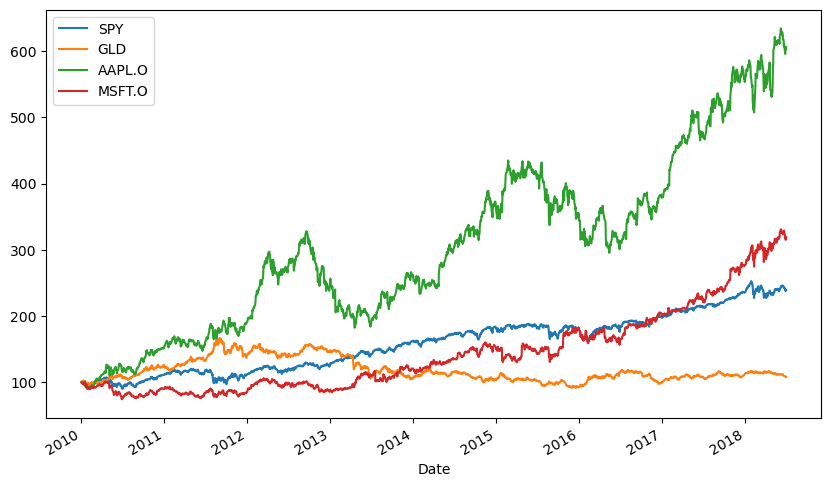

In [36]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6));

We compute the log-returns of the 5 financial products

In [54]:
log_returns = np.log(data / data.shift(1))
log_returns.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.002644,-0.000911,0.001727,0.000323
2010-01-06,0.000704,0.016365,-0.016034,-0.006156
2010-01-07,0.004212,-0.006207,-0.001850,-0.010389
2010-01-08,0.003322,0.004951,0.006626,0.006807


According to the default assumption of the thoery the distribution of the log-returns should be Gaussian but, as we can see from the plots, even if the distributions look somewhat symmetric, the tails seem to be heavier than those of a Gaussian distribution.

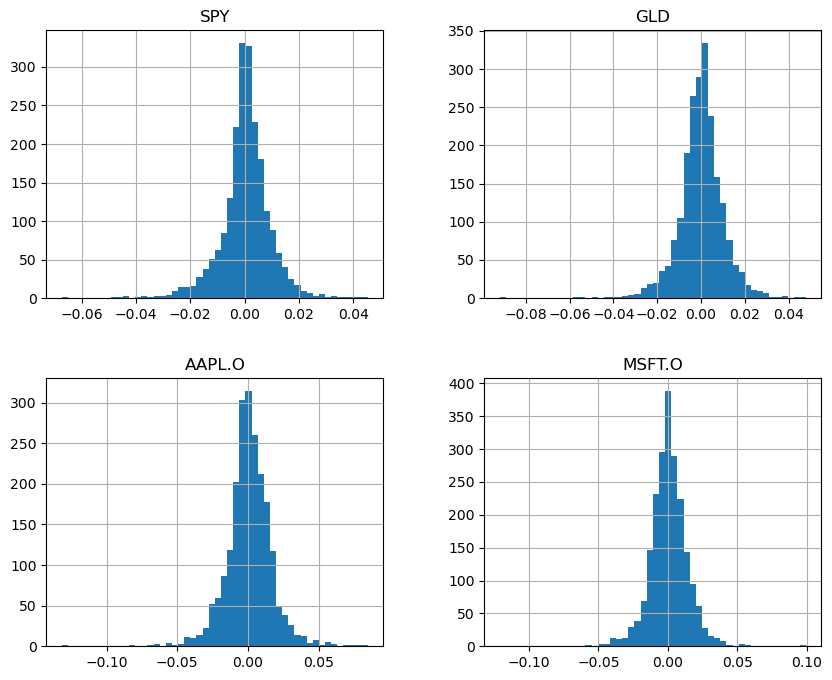

In [39]:
log_returns.hist(bins=50, figsize=(10, 8));

As we have done with the synthetic data, we can measure the distance from a normal distribution by looking at the skewness (symmetry) and the kurtosis (fat-tails).

In [41]:
for sym in symbols:
    print('\nResults for symbol {}'.format(sym))
    print(30 * '-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)


Results for symbol SPY
------------------------------
     statistic           value
------------------------------
          size      2137.00000
           min        -0.06734
           max         0.04545
          mean         0.00041
           std         0.00933
          skew        -0.52189
      kurtosis         4.52432

Results for symbol GLD
------------------------------
     statistic           value
------------------------------
          size      2137.00000
           min        -0.09191
           max         0.04795
          mean         0.00004
           std         0.01020
          skew        -0.59934
      kurtosis         5.68423

Results for symbol AAPL.O
------------------------------
     statistic           value
------------------------------
          size      2137.00000
           min        -0.13187
           max         0.08502
          mean         0.00084
           std         0.01591
          skew        -0.23510
      kurtosis         4.7

Also the quantile-quantile plot, here for the SPY, shows that the real-world data differs from being normally distributed. In particular, the left and right side of the data point differ from the Gaussian plot. This means that the tails are thicker compared to the tails of a Gaussian distribution. 

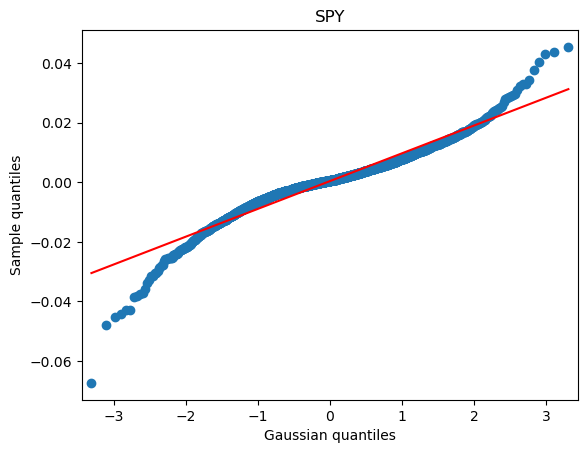

In [42]:
sm.qqplot(log_returns['SPY'].dropna(), line='s')
plt.title('SPY')
plt.xlabel('Gaussian quantiles')
plt.ylabel('Sample quantiles');

Assuming the null hypothesis that the real-world data are normally distributed we perform the normality tests based on the SciPy methods to calculate the skewness and the kurtosis. As we can see from the results, both skewness and particularly the kurtosis are far from the values of a Gaussian distribution and since the p-values are practically zero we have to reject the null hypothesis. 

In [59]:
significance_level = 0.01
for sym in symbols:
    print('\nResults for symbol {}'.format(sym))
    print(32 * '-')
    log_data = np.array(log_returns[sym].dropna())
    normality_tests(log_data)
    p_value = scs.normaltest(log_data.flatten())[1]
    if (p_value > significance_level):
        print('The Null hypothesis cannot be rejected at the {:.1f}% significance level'.format((1 - significance_level) * 100))
    else:
        print('The null hypothesis must be rejected at the {:.1f}% significance level'.format((1 - significance_level) * 100))


Results for symbol SPY
--------------------------------
Skew of data set         -0.522
Skew test p-value          0.000
Kurt of data set          4.524
Kurt test p-value          0.000
Norm test p-value          0.000
The null hypothesis must be rejected at the 99.0% significance level

Results for symbol GLD
--------------------------------
Skew of data set         -0.599
Skew test p-value          0.000
Kurt of data set          5.684
Kurt test p-value          0.000
Norm test p-value          0.000
The null hypothesis must be rejected at the 99.0% significance level

Results for symbol AAPL.O
--------------------------------
Skew of data set         -0.235
Skew test p-value          0.000
Kurt of data set          4.790
Kurt test p-value          0.000
Norm test p-value          0.000
The null hypothesis must be rejected at the 99.0% significance level

Results for symbol MSFT.O
--------------------------------
Skew of data set         -0.091
Skew test p-value          0.085
Kurt 

## Portfolio optimization
The basic idea of portfolio optimization is to select a number of units of well diversified assets to include in a portfolio. An asset unit is usually a stock. Each asset in the portfolio should be selected after a careful analysis of their past performance and their future forseeable returns. The amount of wealth invested in a number of units of a stock represents its weight in the portfolio. The returns of these assets should be independent of each other, or in statistical terms, they should not be correlated, so that in case one asset has a bad performance the loss will be small and the return of the portfolio may still be positive. We can translate these requiremtes to the mean return and to the voltility of the portfolio.

We select the same dataset and assets as before

In [2]:
filename = 'source/tr_eikon_eod_data.csv'  
with open(filename, 'r') as f:   
    print(f.readlines()[:5])  

['Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD\n', '2010-01-01,,,,,,,,,1.4323,1096.35,,\n', '2010-01-04,30.57282657,30.95,20.88,133.9,173.08,113.33,1132.99,20.04,1.4411,1120.0,47.71,109.8\n', '2010-01-05,30.625683660000004,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7\n', '2010-01-06,30.138541290000003,30.77,20.8,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5,49.34,111.51\n']


In [3]:
raw = pd.read_csv(filename, index_col=0, parse_dates=True)
raw.head(3)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.8
2010-01-05,30.625684,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7


We compute the daily returns from the prices of the selected stocks

In [4]:
symbols = ['AAPL.O', 'MSFT.O', 'SPY', 'GLD']
data = raw[symbols]
rets = np.log(data / data.shift(1))

We calculate the yearly mean return of the stocks

In [5]:
num_trading_days = 252
rets.mean() * num_trading_days

AAPL.O    0.181303
MSFT.O    0.124840
SPY       0.097286
GLD      -0.003784
dtype: float64

We calculate their covariance matrix

In [6]:
rets.cov() * num_trading_days

,AAPL.O,MSFT.O,SPY,GLD
AAPL.O,0.064034,0.023656,0.021154,0.001428
MSFT.O,0.023656,0.051211,0.022390,-0.000370
SPY,0.021154,0.022390,0.022049,0.000108
GLD,0.001428,-0.000370,0.000108,0.025945


The portfolio return $R_t^{portf}$ is the returns of each security in the portfolio

$$R_t^{portf} = w^Tr_t$$

where $r_t$ is the matrix of the periodic (e.g. daily) returns of the stocks in the portfolio. We choose the weights randomly for the purpose of the example. 

In [7]:
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.10646142, 0.33169908, 0.20005855, 0.36178095])

The expected return of a portfolio of p stocks over N periods, e.g. days, is defined, assuming independent and identically distributed random observations, as

$$E[R_t^{portf}] = w^T \mu$$

where 

$$\mu = \frac{1}{N} \sum_{t=1}^N r_{it}$$

and w is the vector of the weights of the stocks in the portfolio. We can calculate the yearly portfolio return with a line of code

In [8]:
np.sum(rets.mean() * weights) * num_trading_days

0.07880509047628761

The volatility is defined as the standard deviation of the portfolio returns (see p.156)

$$\sigma_p = \sqrt{w^T \Sigma w}$$

where $\Sigma$ is the covariance matrix of the portfolio returns and w is the normalized vector of the weights of the stocks in the portfolio. We can calculate the variance and the standard deviation with two lines of code

The Sharpe ratio (SR) is defined as the risk-adjusted expected excess return

$$SR = \frac{w^T \mu -r_f}{\sqrt{w^T \Sigma w}}$$

In other words, is the ration between the expected excess return compared to a risk-free asset rate $r_f$ and the portfolio volatility. Assuming $r_f = 0$

In [9]:
var = np.dot(weights.T, np.dot(rets.cov() * num_trading_days, weights))
print('Portfolio variance: {:.2f}'.format(var))

Portfolio variance: 0.02


In [10]:
print('Standard deviation: {:.2f}'.format(math.sqrt(var)))

Standard deviation: 0.13


We define two functions: one to calculate the mean return of a portfolio from the data, given the weights, and the second to calculate its volatility.

In [11]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * num_trading_days

In [12]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * num_trading_days, weights)))

In [39]:
port_vol(weights)

0.18278906077544013

We perform a number of Monte Carlo simulations to calculate the mean return and volatility of a portfolio from the dataset given the (random) weights. From the scatter plot of the returns and volatilities, we can see that the higher the return, the higher is the volatility, that is the risk of the portfolio. For a certain amount of volatility, let's say 15%, the best portfolio weights are those corresponding to the point at the frontier crossed by the vertical line at 0.15. 

In [33]:
prets = []
pvols = []
num_samples = 2500
for p in range (num_samples):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))

In [14]:
prets = np.array(prets)
pvols = np.array(pvols)
sharpe = prets / pvols

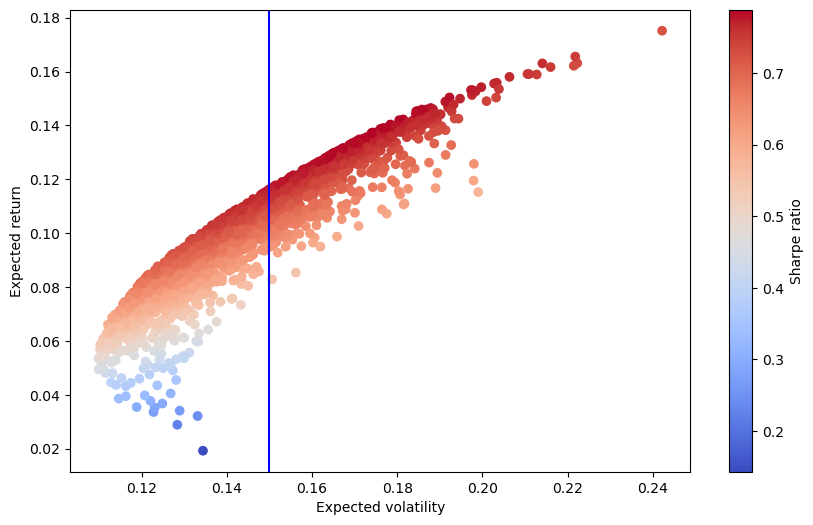

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=sharpe, marker='o', cmap='coolwarm')
plt.axvline(x = 0.15, color = 'blue', label = '40')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio');

### Numerical optimization
The goal of the theory is to calculate the weights of the portfolio to achieve the maximum return with the lowest volatility. The constraints are that the sum of weights is 1.0. We choose the Sharpe ratio (SR) as the function to maximize since its maximum should be a value for which we have the maximum return with the lowest volatility. Instead of maximizing the Sharpe ratio we can minimize its negation.

In [16]:
import scipy.optimize as sco

We define the function to be minimized: the negation of the Sharpe ratio

In [17]:
def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)

In [18]:
constraint = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

We set the bounds for the value of the weights to be within (0, 1)

In [20]:
noa = len(symbols)
bnds = tuple((0, 1) for x in range(noa))

We set as the iinitial guess to start the optimization process a portfolio with equal weights

In [21]:
equal_weights = np.array(noa * [1. / noa,])  
equal_weights 

array([0.25, 0.25, 0.25, 0.25])

In [23]:
min_func_sharpe(equal_weights)

-0.729683392711007

We use the [SciPy minimize()](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html) method, based on the [*Sequential Least Square Programming (SLSQP)*](https://en.wikipedia.org/wiki/Sequential_quadratic_programming) algorithm, to find the minimum of the negation of the Sharpe ratio. The SLSQP algorithm consist of writing the Lagrangian of the function and the constraints using a linearr parameter for each constraint and then calculating the value of the parameters using the classic least square method.

In [29]:
%%time 
opts = sco.minimize(min_func_sharpe, 
                    equal_weights,
                    method='SLSQP', 
                    bounds=bnds,
                    constraints=constraint)  

CPU times: total: 125 ms
Wall time: 102 ms


The minimization method returns a list of values among which we have the optimal weights x, the value of the function given the weights

In [30]:
opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7891296138971186
       x: [ 4.403e-01  1.705e-01  3.892e-01  0.000e+00]
     nit: 6
     jac: [-2.386e-05  8.337e-06  2.337e-05  3.694e-02]
    nfev: 30
    njev: 6

In [35]:
opts['x'].round(3)

array([0.44 , 0.171, 0.389, 0.   ])

We can calculate the optimal portfolio return 

In [36]:
port_ret(opts['x']).round(3)

0.139

its volatility

In [37]:
port_vol(opts['x']).round(3)

0.176

and the optimal (maximum) Sharpe ratio

In [38]:
port_ret(opts['x']) / port_vol(opts['x'])

0.7891296138971186

Another possible portfolio is one that has the minimum volatility. This portfolio might fit better for investors that are more risk averse. We use the volatility function instead of the Sharpe ratio with the same constraint and bounds.

In [40]:
optv = sco.minimize(port_vol, 
                    equal_weights,
                    method='SLSQP', 
                    bounds=bnds,
                    constraints=constraint)

In [41]:
optv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.10942024449846979
       x: [ 2.168e-19  1.540e-03  5.391e-01  4.593e-01]
     nit: 8
     jac: [ 1.108e-01  1.101e-01  1.096e-01  1.092e-01]
    nfev: 41
    njev: 8

We have the new optimal weights

In [42]:
optv['x'].round(3)

array([0.   , 0.002, 0.539, 0.459])

The optimal volatility, lower than that for the Sharpe ratio

In [43]:
port_vol(optv['x']).round(3)

0.109

The optimal return for the new portfolio is lower than before as the less risky portfolio provides a smaller return

In [44]:
port_ret(optv['x']).round(3)

0.051

Finally the Sharpe ratio of the new optimal portfolio that is also lower than before.

In [45]:
port_ret(optv['x']) / port_vol(optv['x'])

0.4652051259174492